#### George Nakhleh
#### CSC 478: Assignment 2
#### Using k-nearest neighbors for classification

#### Question 1: K-Nearest Neighbor classification on Newsgroups
Dataset: [newsgroups.zip](http://facweb.cs.depaul.edu/mobasher/classes/csc478/Data/newsgroups.zip)
Dataset description [here](http://qwone.com/~jason/20Newsgroups/)

Using a subset of the 20 Newsgroup data set (1000 docs and a vocabulary of terms). Each document belonds to one of two classes: Hockey (label 1) and Microsoft Windows (label 0).  
Data has already been split into training and testing sets (80% / 20%), and preprocessed to handle stopwords and perform stemming.  
Class labels are provided in separate files. There is a row for each term in the vocabulary and a column for each document, values are raw term frequencies.  
For these questions, **scikit-learn won't be used**

#### Basic EDA
Understanding the data

In [1]:
#Import packages we'll need
import numpy as np
import pandas as pd

#Files we need:
#Training data matrix
train_data = pd.read_table("newsgroups/trainMatrixModified.txt", header=None)

#Training labels
train_labels = pd.read_table("newsgroups/trainClasses.txt", header=None)


In [2]:
train_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
#training data shape
print("DF shape: {}".format(train_data.shape))

DF shape: (5500, 800)


In [4]:
train_labels.head(5)

,0,1
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [5]:
#remove the first column of the training labels
train_labels.drop(0, axis=1, inplace=True)
train_labels.head(15)

,1
0,0
1,1
2,0
3,1
4,0
5,1
6,1
7,1
8,1
9,1


In [6]:
train_labels.shape

(800, 1)

In [7]:
#rotate the training data to be a document-term matrix:
train_data_docterm = train_data.T
train_data_docterm.head(5)

,0,1,2,3,4,5,6,7,8,9,...,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499
0,2.0,2.0,2.0,1.0,8.0,6.0,2.0,8.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Bring in the vocabulary of terms
terms = np.genfromtxt("newsgroups/modifiedterms.txt", dtype=str)
terms[0:30]

array(['david', 'rex', 'wood', 'subject', 'call', 'librari', 'creat',
       'widget', 'multipl', 'time', 'dai', 'ago', 'post', 'question',
       'try', 'function', 'set', 'app', 'point', 'xtappiniti', 'help',
       'have', 'problem', 'littl', 'test', 'program', 'close', 'model',
       'real', 'actual'], 
      dtype='<U79')

In [9]:
len(terms)

5500

Analyze term frequency by forming a dictionary of terms and their counts in the document-term matrix (ie columns of the DF). See [example](http://facweb.cs.depaul.edu/mobasher/classes/csc478/Notes/IPython%20Notebook%20-%20Term-Doc-KNN.html)

In [10]:
termFreqs = train_data_docterm.sum(axis=1)

dictTF = {}
for i in range(len(termFreqs)):
    dictTF[terms[i]] = termFreqs[i]
print(sorted(dictTF.items()))
sortedTF = sorted(dictTF.values(), reverse=True)

[('00', 159.0), ('10', 254.0), ('1010', 105.0), ('125', 74.0), ('14', 100.0), ('1990', 73.0), ('1991', 159.0), ('1992', 23.0), ('1993', 80.0), ('1st', 67.0), ('20', 32.0), ('21', 61.0), ('25', 136.0), ('2nd', 24.0), ('30', 59.0), ('4324219', 24.0), ('50', 78.0), ('5000', 286.0), ('63', 44.0), ('635', 42.0), ('705', 78.0), ('89', 204.0), ('919', 113.0), ('999', 32.0), ('abc', 172.0), ('abl', 73.0), ('accept', 195.0), ('access', 53.0), ('act', 168.0), ('activ', 107.0), ('actual', 485.0), ('adam', 81.0), ('add', 205.0), ('addit', 53.0), ('address', 31.0), ('admit', 81.0), ('admittedli', 202.0), ('advanc', 125.0), ('advantag', 45.0), ('advic', 75.0), ('afternoon', 102.0), ('ago', 78.0), ('allstar', 47.0), ('altern', 2.0), ('amount', 330.0), ('analyst', 51.0), ('anderson', 99.0), ('andrewcmuedu', 28.0), ('angel', 253.0), ('angelo', 72.0), ('announc', 48.0), ('anonym', 28.0), ('anybodi', 89.0), ('anymor', 89.0), ('anywai', 792.0), ('app', 50.0), ('appear', 214.0), ('appropri', 74.0), ('archi

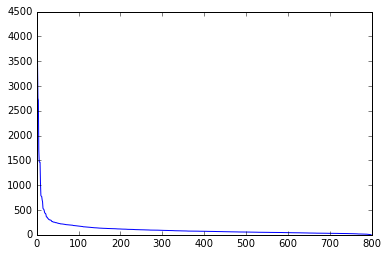

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sortedTF)
plt.show()

#### 1a) Create a KNN classifier. 
It should allow as input the training data matrix, the training labels, the instance to be classified, the value of K. It should return the predicted classes for the instance, and the top K neighbors.  
The classifier should work with Euclidean distance and Cosine Similarity. If necessary, can make 2 separate classifiers.

In [12]:
#Items we need

#training data matrix
train_data_docterm = np.array(train_data_docterm)

#training labels
doc_labels_training = list(train_labels[1])

k = 5

In [13]:
print("Training data (doc-term) dimensions: {} \nTraining labels is a list of length {}"\
      .format(train_data_docterm.shape, len(doc_labels_training)))

Training data (doc-term) dimensions: (800, 5500) 
Training labels is a list of length 800


**The function**  
- Allows for both Euclidean distance and cosine similarity  
- Returns predicted class (actual text, not coded binary) and term frequency of k-nearest neighbors (useful for inspection?)

In [29]:
import operator

def knn_function(inX, dataSet, labels, k, measure):
    #Find K nearest neighbors of the data among D
    #Calculate the distance conditionally based on the measure given
    if measure == 0:
        dataSetSize = dataSet.shape[0]
        #Instead of iterating for row vs row diff's, we can calculate the diff matrix at the array-level
        diffMat = np.tile(inX, (dataSetSize,1)) - dataSet
        sqDiffMat = diffMat**2
        sqDistances = sqDiffMat.sum(axis=1)
        distances = sqDistances**0.5

    elif measure == 1:
        D_norm = np.array([np.linalg.norm(dataSet[i]) for i in range(len(dataSet))])
        x_norm = np.linalg.norm(inX)
        cosines = np.dot(dataSet,inX)/(D_norm * x_norm)
        distances = 1 - cosines
    
    #Once we have the distance, work on returning nearest neighbors
    sortedDistIndicies = np.argsort(distances)
    classCount={}
    neighbor_idx = sortedDistIndicies[:k]
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    predicted_class = sortedClassCount[0][0]
    return predicted_class, dataSet[neighbor_idx]

In [15]:
#A row from the training data
vec_for_function = train_data_docterm[2]
vec_for_function.shape

(5500,)

Trying out the function

In [30]:
predicted_class, k_neighbors = knn_function(vec_for_function, train_data_docterm, doc_labels_training, 5, 1)

print("Predicted class: {} \n k-nearest neighbors:\n{}".format(predicted_class, k_neighbors))

Predicted class: 0 
 k-nearest neighbors:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


#### 1b): Create a function to compute the classification accuracy over the test data set (ratio of correct predictions to the number of test instances). 
This function will call the classifier function on all the test instances and in each case compares the actual test class label to the predicted class label.

In [17]:
#So we need the test instances and their labels

#Training data matrix
test_data = pd.read_table("newsgroups/testMatrixModified.txt", header=None)
#Turn into a doc-term matrix
test_data_docterm = np.array(test_data.T)


#Training labels
test_labels = pd.read_table("newsgroups/testClasses.txt", header=None)
test_labels.drop(0, axis=1, inplace=True)
#Turn into a list of classes
doc_labels_test = list(test_labels[1])

**The function**  
- Careful to understand how knn function works, and what happens when it's nested within this new testing function

In [98]:
#Now we'll run rows of the testing data in the knn function

def knn_tester(numTestVecs, testData, trainData, labels, k, measure):
    errorCount = 0.0
    for i in range(numTestVecs):
        #Use the first i rows of the testing data, one-by-one, in the knn function
        predicted_class, neighbors = knn_function(testData[i,:], trainData, doc_labels_training, k, measure)
        #If the two classes don't match, add 1 to the error count
        if (predicted_class != labels[i]): errorCount += 1.0
    #Give the accuracy
    if measure == 0:
        print("\nClassified {} documents. \nThe total ACCURACY using Euclidean distance is: {}%".format(numTestVecs, 100*(1 - (errorCount/float(numTestVecs)))))
    elif measure == 1:
        print("\nClassified {} documents. \nThe total ACCURACY using Cosine similarity is: {}%".format(numTestVecs, 100*(1 - (errorCount/float(numTestVecs)))))


The function seems to work

In [99]:
knn_tester(numTestVecs=10, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 10, measure = 1)


Classified 10 documents. 
The total ACCURACY using Cosine similarity is: 100.0%


#### 1c) Use the testing function on various amounts of test data rows, using both Euclidean and Cosine measures of distance

In [100]:
# Euclidean vs Cosine
# 10 testing docs
# 5 nearest neighbors
print(knn_tester(numTestVecs=10, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 5, measure = 0), "\n",
      knn_tester(numTestVecs=10, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 5, measure = 1))


Classified 10 documents. 
The total ACCURACY using Euclidean distance is: 90.0%

Classified 10 documents. 
The total ACCURACY using Cosine similarity is: 100.0%
None 
 None


In [101]:
# 10 testing docs
# 10 nearest neighbors
print(knn_tester(numTestVecs=10, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 10, measure = 0), "\n",
      knn_tester(numTestVecs=10, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 10, measure = 1))


Classified 10 documents. 
The total ACCURACY using Euclidean distance is: 80.0%

Classified 10 documents. 
The total ACCURACY using Cosine similarity is: 100.0%
None 
 None


In [102]:
# 30 testing docs
# 5 nearest neighbors
print(knn_tester(numTestVecs=30, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 5, measure = 0), "\n",
      knn_tester(numTestVecs=30, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 5, measure = 1))


Classified 30 documents. 
The total ACCURACY using Euclidean distance is: 83.33333333333334%

Classified 30 documents. 
The total ACCURACY using Cosine similarity is: 96.66666666666667%
None 
 None


In [103]:
# 30 testing docs
# 10 nearest neighbors
print(knn_tester(numTestVecs=30, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 10, measure = 0), "\n",
      knn_tester(numTestVecs=30, testData = test_data_docterm, trainData = train_data_docterm, labels = doc_labels_test, k = 10, measure = 1))


Classified 30 documents. 
The total ACCURACY using Euclidean distance is: 76.66666666666666%

Classified 30 documents. 
The total ACCURACY using Cosine similarity is: 93.33333333333333%
None 
 None


#### Results
It seems that cosine similarity outperforms Euclidean distance in this application. It is more accurate, and suffers less problems when given a larger number of neighbors. 

#### 1d) Modify the training and test datasets so term weights are converted to TFxIDF weights (instead of raw term frequencies). Then rerun the evaluation on the range of K values (same as above) and compare results.

So how do we get our datasets into term frequency x inverse document frequency format?  
  
Formula: *w = tf x log(N / n)*  
- T = a term in document D  
- tf = frequency of that term T in document D  
- idf = inverse document frequency of term T in C  
- N = total number of docs in the collection C  
- n = the number of docs in C that contain term T  
- idf = log(N/n)  

In [107]:
#We already computed term frequency:
train_data = pd.read_table("newsgroups/trainMatrixModified.txt", header=None)

#For the testing data
test_data = pd.read_table("newsgroups/testMatrixModified.txt", header=None)

**The function**: converts a term-document matrix into a tf-idf matrix

In [108]:
#A function for converting a term-document matrix into tf-idf format
def tf_idf_converter(term_doc_mat):
    #rotate the matrix so rows are doc's and col's are terms
    tf_mat = np.array(term_doc_mat.T)
    #N = number of docs (length of new doc-term matrix)
    N = tf_mat.shape[0]
    #Define n for each column (term) and get tf x idf for each column
    for col in range(tf_mat.shape[1] - 1):
        n = tf_mat[:, col].astype(bool).sum()
        tf_mat[:, col] = tf_mat[:, col] * np.log(N/n)
    return tf_mat

In [109]:
#Create tf-idf matrices for the training and testing sets
train_tfidf = tf_idf_converter(train_data)
test_tfidf = tf_idf_converter(test_data)

In [110]:
#Did it work?
print(train_tfidf[0,0], np.array(train_data.T)[0,0])

5.54517744448 2.0


In [111]:
vec_for_function = train_tfidf[3,:]

In [112]:
#Use these as inputs for the knn function
predicted_class, k_neighbors = knn_function(vec_for_function, 
                                            train_tfidf, doc_labels_training, 
                                            5, 1)

print("Predicted class: {} \n k-nearest neighbors:\n{}".format(predicted_class, k_neighbors))

Predicted class: 1 
 k-nearest neighbors:
[[ 5.54517744  0.          0.         ...,  0.          0.          0.        ]
 [ 5.54517744  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


Test the KNN function using the tf-idf matrices

In [113]:
#Test the knn function when using tf idf matrices
print(knn_tester(numTestVecs=30, testData = test_tfidf, trainData = train_tfidf, labels = doc_labels_test, k = 5, measure = 0), "\n",
      knn_tester(numTestVecs=30, testData = test_tfidf, trainData = train_tfidf, labels = doc_labels_test, k = 5, measure = 1))


Classified 30 documents. 
The total ACCURACY using Euclidean distance is: 50.0%

Classified 30 documents. 
The total ACCURACY using Cosine similarity is: 50.0%
None 
 None


In [114]:
print(knn_tester(numTestVecs=50, testData = test_tfidf, trainData = train_tfidf, labels = doc_labels_test, k = 5, measure = 0), "\n",
      knn_tester(numTestVecs=50, testData = test_tfidf, trainData = train_tfidf, labels = doc_labels_test, k = 5, measure = 1))


Classified 50 documents. 
The total ACCURACY using Euclidean distance is: 48.0%

Classified 50 documents. 
The total ACCURACY using Cosine similarity is: 48.0%
None 
 None


**Results**  
Seems that simply subbing in the tf-idf matrices into the same KNN function reduces accuracy.  
Oddly, the performance of the two distance measures is now identical **(error??)**